<img title="GitHub Octocat" src='https://github.com/pessini/moby-bikes/blob/902858f47ba9afaf380abfc2be02a2b7f1f09174/notebooks/img/Octocat.jpg?raw=true' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import scipy.stats as stats
from patsy import dmatrices

# statsmodels
from statsmodels.stats import diagnostic as diag
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
%reload_ext watermark
%watermark -a "Leandro Pessini" -n -u -v -iv -w

Author: Leandro Pessini

Last updated: Sun May 15 2022

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 8.3.0

pandas     : 1.3.0
sys        : 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) 
[Clang 11.1.0 ]
statsmodels: 0.13.2
numpy      : 1.21.1
seaborn    : 0.11.1
scipy      : 1.8.0
matplotlib : 3.4.2

Watermark: 2.3.0



In [19]:
df_train = pd.read_csv('../data/processed/df_train.csv')
df_test = pd.read_csv('../data/processed/df_test.csv')
all_data = pd.read_csv('../data/processed/rentals_data.csv')

## Outlier Analysis

### Unusual Observations (Outliers) and High Leverage Observations
- We have a few outliers but not sure if they can be treated as inacurates as they capture the data.
- High Leverage Observations are unusual values on the predictors that can dramatically affect the model. In a regression analysis, single observations can have a strong influence on the results of the model.

Influencial Points (not all unusual observations have much of an impact on the model) - https://www.kirenz.com/post/2021-11-14-linear-regression-diagnostics-in-python/linear-regression-diagnostics-in-python/

In [4]:
expr = \
     """ count ~ temp_bin + wind_speed_group + rhum_bin + rainfall_intensity + holiday + timesofday"""
y_train, X_train = dmatrices(expr, df_train, return_type = 'dataframe')
nb_training_results = sm.GLM(y_train, X_train, family = sm.families.NegativeBinomial(alpha = 1)).fit(maxiter=5000, method='nm', cov_type='HC3')

We can use influence plots to identify observations in our independent variables which have “unusual” values in comparison to other values.

Influence plots show the (externally) studentized residuals vs. the leverage of each observation:

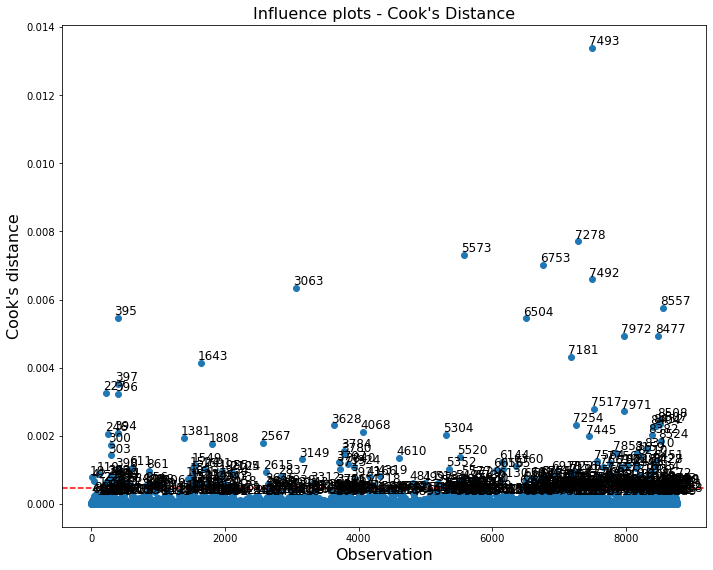

In [5]:
infl = nb_training_results.get_influence(observed=False)
fig, ax = plt.subplots(figsize=(10, 8))
infl.plot_index(y_var="cooks", threshold=3 * infl.cooks_distance[0].mean(), 
                ax=ax, title="Influence plots - Cook's Distance")
fig.tight_layout(pad=1.0)
plt.axhline(4 / df_train.shape[0], color='r', linestyle='--')
plt.show()

A data point that has a large value for Cook’s Distance indicates that it strongly influences the fitted values. A general rule of thumb is that any point with a Cook’s Distance over 4/n (where n is the total number of data points) is considered to be an outlier.

In [6]:
# obtain Cook's distance 
model_cooksd = infl.cooks_distance[0]
threshold_c = 4 / df_train.shape[0]
out_d = model_cooksd > threshold_c
subset_data = df_train[~out_d]
print(f'Number of possible outliers: {df_train.shape[0] - subset_data.shape[0]}')

Number of possible outliers: 200


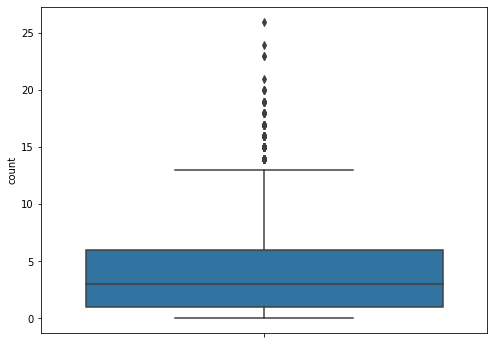

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df_train,
            y="count",
            orient="v",ax=ax)
plt.show()

In [8]:
hourlyDataOutliers = df_train[df_train['count'] > 14]
hourlyDataWithoutOutliers = df_train[df_train['count'] <= 14]
    
print(f"Outliers (#): {round(hourlyDataOutliers.shape[0], 2)}")
print(f"Outliers (%): {round((hourlyDataOutliers.shape[0] / df_train.shape[0])*100, 2)}%")

Outliers (#): 91
Outliers (%): 1.04%


In [9]:
hourlyDataOutliers['holiday'].value_counts()

False    85
True      6
Name: holiday, dtype: int64

In [10]:
hourlyDataOutliers['working_day'].value_counts(normalize=True)

False    0.505495
True     0.494505
Name: working_day, dtype: float64

In [11]:
hourlyDataOutliers['season'].value_counts()

Spring    43
Winter    21
Summer    18
Autumn     9
Name: season, dtype: int64

Unusual observations do not seem to be related with *Holiday* nor Weekends (*Working_Day*). 

In [12]:
daily_count = df_train.groupby('date')['count'].sum().reset_index()
daily_count_no_outliers = hourlyDataWithoutOutliers.groupby('date')['count'].sum().reset_index()

<AxesSubplot:ylabel='count'>

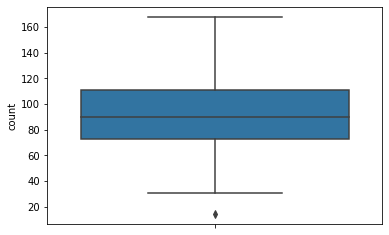

In [30]:
sns.boxplot(data=daily_count,y="count",orient="v")

In [33]:
daily_count[daily_count['count'] < 20]

,date,count
299,2021-12-25,14


The "*outlier*" showed on the boxplot is on Christmas Day.

In [36]:
daily_count.loc[295:302]

,date,count
295,2021-12-21,71
296,2021-12-22,66
297,2021-12-23,94
298,2021-12-24,44
299,2021-12-25,14
300,2021-12-26,33
301,2021-12-27,34
302,2021-12-28,42


In [13]:
mean_daily = daily_count['count'].mean()
std_dev_daily = daily_count['count'].std()
slice_daily = mean_daily + (2*std_dev_daily)
daily_count[daily_count['count'] > slice_daily]

,date,count
6,2021-03-07,157
16,2021-03-17,168
18,2021-03-19,151
19,2021-03-20,148
33,2021-04-03,155
47,2021-04-17,152
54,2021-04-24,163
55,2021-04-25,168
138,2021-07-17,162
144,2021-07-23,154


In [28]:
march_07 = df_train[df_train['date'] == '2021-03-07']
march_07[['hour', 'rain', 'temp', 'rhum', 'wdsp', 'season', 'timesofday','working_day', 'count']]

,hour,rain,temp,rhum,wdsp,season,timesofday,working_day,count
144,0,0.0,1.8,71,3,Winter,Night,False,2
145,1,0.0,1.0,71,4,Winter,Night,False,2
146,2,0.0,0.4,76,4,Winter,Night,False,0
147,3,0.0,1.3,72,4,Winter,Night,False,1
148,4,0.0,0.5,77,4,Winter,Night,False,0
149,5,0.0,0.8,77,5,Winter,Night,False,0
150,6,0.0,0.8,77,6,Winter,Night,False,0
151,7,0.0,0.8,77,6,Winter,Morning,False,0
152,8,0.0,1.8,73,6,Winter,Morning,False,1
153,9,0.0,3.3,69,6,Winter,Morning,False,12


In [26]:
april_25 = df_train[df_train['date'] == '2021-04-25']
april_25[['hour', 'rain', 'temp', 'rhum', 'wdsp', 'season', 'timesofday', 'count']]

,hour,rain,temp,rhum,wdsp,season,timesofday,count
1320,0,0.0,5.3,89,3,Spring,Night,1
1321,1,0.0,6.3,85,3,Spring,Night,0
1322,2,0.0,3.7,90,2,Spring,Night,1
1323,3,0.0,2.4,95,2,Spring,Night,2
1324,4,0.0,3.8,98,5,Spring,Night,0
1325,5,0.0,4.6,97,8,Spring,Night,0
1326,6,0.0,5.7,97,6,Spring,Night,2
1327,7,0.0,8.5,86,7,Spring,Morning,0
1328,8,0.0,8.8,81,12,Spring,Morning,2
1329,9,0.0,9.7,73,12,Spring,Morning,12


In [14]:
daily_count.describe()

,count
count,365.000000
mean,90.520548
std,27.895168
min,14.000000
25%,73.000000
50%,90.000000
75%,111.000000
max,168.000000


In [15]:
print(f"Mean of daily rentals = {round(daily_count['count'].mean(), 2)}")
print(f"Mean of daily rentals without Outliers = {round(daily_count_no_outliers['count'].mean(), 2)}")

Mean of daily rentals = 90.52
Mean of daily rentals without Outliers = 86.31


In [16]:
hourlyDataOutliers = hourlyDataOutliers.join(daily_count.set_index('date'), on='date', lsuffix='_hour', rsuffix='_day')

In [17]:
outliers_df = hourlyDataOutliers[hourlyDataOutliers['count_day'] > 110].sort_values(by='count_day', ascending=False)
outliers_df.head()

,rain,temp,rhum,wdsp,date,hour,day,month,year,count_hour,...,season,peak,timesofday,rainfall_intensity,wind_bft,wind_speed_group,temp_r,temp_bin,rhum_bin,count_day
1333,0.0,10.8,60,14,2021-04-25,13,25,4,2021,18,...,Spring,False,Afternoon,no rain,4,Moderate Breeze,11,5.0,1.0,168
395,0.0,8.7,81,12,2021-03-17,11,17,3,2021,18,...,Winter,False,Morning,no rain,4,Moderate Breeze,9,4.0,3.0,168
396,0.0,10.3,71,9,2021-03-17,12,17,3,2021,19,...,Winter,False,Afternoon,no rain,3,Breeze,10,4.0,2.0,168
397,0.0,11.4,66,11,2021-03-17,13,17,3,2021,23,...,Winter,False,Afternoon,no rain,4,Moderate Breeze,11,5.0,1.0,168
398,0.0,11.9,60,12,2021-03-17,14,17,3,2021,15,...,Winter,False,Afternoon,no rain,4,Moderate Breeze,12,5.0,1.0,168


In [18]:
hourlyDataOutliers.to_csv('../data/interim/outliers.csv')

<img title="GitHub Mark" src="https://github.com/pessini/moby-bikes/blob/902858f47ba9afaf380abfc2be02a2b7f1f09174/notebooks/img/GitHub-Mark-64px.png?raw=true" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini